In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

seed=1
torch.manual_seed(seed)
np.random.seed(seed)

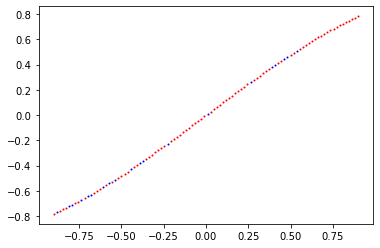

In [2]:
N=int(1e2) # number of data
x=np.linspace(-.9,.9,N)
y=np.sin(x)

idx_train=(np.random.choice(N,80,replace=0))
idx_test = np.setdiff1d(np.arange(N), idx_train)

x_train=x[idx_train]
y_train=y[idx_train]

x_test=x[idx_test]
y_test=y[idx_test]

plt.scatter(x_train,y_train,s=1,c='r')
plt.scatter(x_test,y_test,s=1,c='b')
plt.show()

In [3]:
## device choice

device = 'mps' if torch.backends.mps.is_built()  else 'cpu'
device = 'cpu'


# # GPU 사용 가능일 경우 랜덤 시드 고정
# if device == 'mps':
#     # torch.backends.mps.manual_seed_all(seed)
#     torch.backends.mps.is_available()

print("learning with",device)

learning with cpu


In [4]:
# 신경망 정의
class NN(nn.Module):
    def __init__(self, num1, num2):
        self.num1 = num1 # nodes per hidden layer
        self.num2 = num2 # number of hidden layer

        super(NN, self).__init__()
        self.layer_in = nn.Sequential(
            nn.Linear(1,self.num1),
            nn.ReLU())
        self.layer_hidden = nn.Sequential(
            nn.Linear(self.num1,self.num1),
            nn.ReLU())
        self.layer_out = nn.Sequential(
            nn.Linear(self.num1,1),
            # nn.ReLU()) # 이거로 하면 바로 0으로 가서 학습하는게 의미 없어짐
            nn.Sigmoid()) # 20번 학습하면 1e-9 order로 수렴함

        self.hidden=nn.ModuleList()
        for i in range(self.num2):
            self.hidden.append(self.layer_hidden)
        
        
        # 가중치를 고르게하는 건데 이 잘 안돼네....
        # nn.init.xavier_uniform_(self.layer1.weight) # 지금까지는 대충 설정했는데
        # nn.init.xavier_uniform_(self.layer2.weight) # 지금까지는 대충 설정했는데

    def forward(self, x): # 순서대로 대입해서 출력하는 것뿐 
        out = self.layer_in(x)
        for layer in self.hidden:
            out = layer(out)
        out = self.layer_out(out)
        return out

# model = NN(3,1).to(device)

In [5]:
## training
nodes_per_hidden_layer=5
number_of_hidden_layer=2
model = NN(nodes_per_hidden_layer,number_of_hidden_layer).to(device)
# from torchinfo import summary
# print(summary(model))
# print(model)


lr=1e-2
epochs=20
batch_size = 1

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss().to(device)


In [6]:
## set data
from torch.utils.data import TensorDataset, DataLoader
# array to tensor
train_data = torch.Tensor(x_train)
test_data = torch.Tensor(x_test)
train_label = torch.LongTensor(y_train)
test_label = torch.LongTensor(y_test)

# 데이커와 라벨 묶기
ds_train = TensorDataset(train_data, train_label)
ds_test = TensorDataset(test_data, test_label)

# 베치 나누기
train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)
total_batch = len(train)


In [7]:
## train
costh=[]
for epoch in range(epochs):
    avg_cost = 0

    for X, Y in train: # 미니 배치 단위로 꺼내온다. X는 이미지, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        # print(hypothesis)
        # print(Y)
        cost = criterion(hypothesis.to(torch.float32), Y.to(torch.float32))
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    # print(avg_cost.item())
    # print(type(avg_cost))
    # avg_cost=avg_cost.detach().numpy()
    avg_cost=avg_cost.item()
    print('[Epoch: {:>2}] cost = {:>.6}'.format(epoch + 1, avg_cost))
    # os.system(f"say {epoch + 1} epoch done {epoch + 1} epoch done")
    costh.append(avg_cost)


[Epoch:  1] cost = 0.0615456
[Epoch:  2] cost = 1.43787e-05
[Epoch:  3] cost = 1.05493e-05
[Epoch:  4] cost = 7.86952e-06
[Epoch:  5] cost = 5.98243e-06
[Epoch:  6] cost = 4.64819e-06
[Epoch:  7] cost = 3.69035e-06
[Epoch:  8] cost = 2.97875e-06
[Epoch:  9] cost = 2.44771e-06
[Epoch: 10] cost = 2.03935e-06
[Epoch: 11] cost = 1.72036e-06
[Epoch: 12] cost = 1.46741e-06
[Epoch: 13] cost = 1.2632e-06
[Epoch: 14] cost = 1.09768e-06
[Epoch: 15] cost = 9.60605e-07
[Epoch: 16] cost = 8.45919e-07
[Epoch: 17] cost = 7.49986e-07
[Epoch: 18] cost = 6.67707e-07
[Epoch: 19] cost = 5.97984e-07
[Epoch: 20] cost = 5.37907e-07


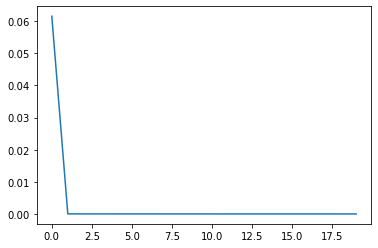

In [8]:
plt.plot(range(epochs),costh)
plt.show()



In [9]:
# torch.save(model, "./gpu_model_save.pth")
# model_c = torch.load("./gpu_model_save.pth", map_location=device)
# model_c.eval() # 모델 활성화!
# print(train_data[1])



# yy=[]
# z=0
# while z<len(train_data):
#     model(train_data[z])
#     z+=1
# plt.plot(train_data,yy)
# plt.show()